# 0. Setting Up The Env

## 0.1 Packages

In [10]:
from pathlib import Path

In [11]:
import pandas as pd 
import numpy as np

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


In [13]:
from scipy.stats import chi2_contingency

## 0.2 Utilities

In [14]:
def cramers_v(x, y):
    """
    Calculate Cramér's V statistic 
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, exp = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))), chi2, p

def association_with_target(df, x_list, y):
    """
    Test association between target categorical variable y and categorical features in x_list.
    """
    results = []
    for col in x_list:
        v, chi2, p = cramers_v(df[col], df[y])
        results.append({
            "Feature": col,
            "Target": y,
            "Cramer's V": round(v, 3),
            "Chi2 Statistic": round(chi2, 3),
            "p-value": round(p, 5),
            "Significance": "Significant" if p < 0.05 else "Not Significant"
        })
    return pd.DataFrame(results)

## 0.3 Constants

In [15]:
project_root = Path.cwd().parent
project_root

WindowsPath('d:/01 Work/06-Segmentations')

In [16]:
raw_file_path = f"{project_root}/data/raw/bank-full.csv"
raw_file_path

'd:\\01 Work\\06-Segmentations/data/raw/bank-full.csv'

# 1. The Data

In [17]:
data_df  = pd.read_csv(raw_file_path, sep=";")
print(f"The data has {data_df.shape[0]} rows and {data_df.shape[1]} columns")
print("Data Preview:")
data_df.head()

The data has 45211 rows and 17 columns
Data Preview:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# 2. Data Check

In [18]:
print(data_df.isnull().sum())




age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [19]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## 2.1 Target Var

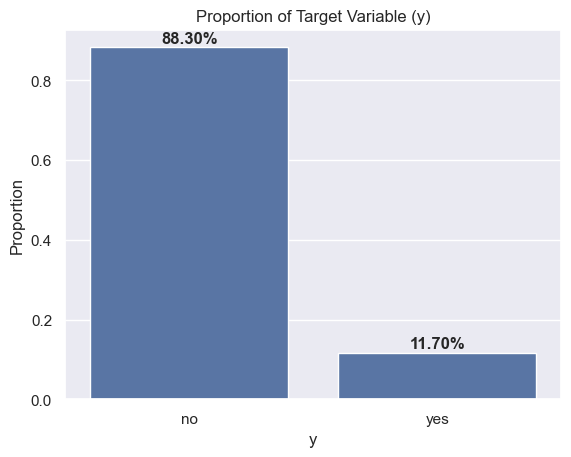

In [20]:
ax = sns.barplot(
    x=data_df['y'].value_counts(normalize=True).index,
    y=data_df['y'].value_counts(normalize=True).values,
)

# Add percentage labels
for i, v in enumerate(data_df['y'].value_counts(normalize=True).values):
    ax.text(i, v + 0.01, f"{v:.2%}", ha="center", fontweight="bold")

ax.set_title("Proportion of Target Variable (y)")
ax.set_xlabel("y")
ax.set_ylabel("Proportion")
plt.show()

## 2.2 Numeric Columns

In [21]:
data_df.describe().T


,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


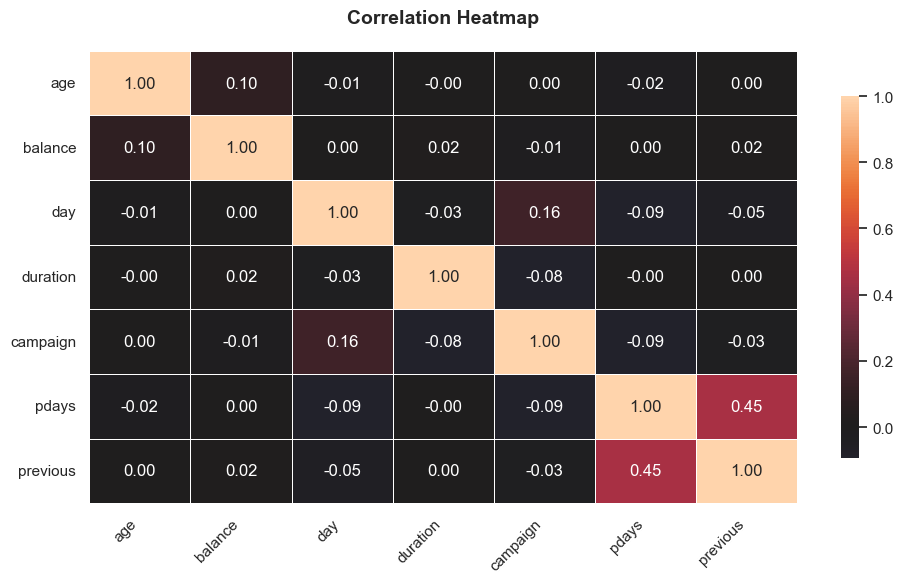

In [22]:
plt.figure(figsize=(10, 6))
corr = data_df.corr(numeric_only=True)

ax = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",              # format correlations
    center=0,               # center at 0 for diverging colormap
    linewidths=0.5,         # add grid lines
    cbar_kws={"shrink": .8} # shrink colorbar for readability
)

ax.set_title("Correlation Heatmap", fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha="right")   # rotate x labels
plt.yticks(rotation=0)                # keep y labels horizontal
plt.tight_layout()
plt.show()

No strong correlations between anything, other than **pdays**(*number of days that passed by after the client was last contacted from a previous campaign*) and **previous**(*number of contacts performed before this campaign and for this client*) which shows medium correlationship

## 2.3 Categorical Columns

In [23]:
data_df.describe(include=['O']).T

,count,unique,top,freq
job,45211,12,blue-collar,9732
marital,45211,3,married,27214
education,45211,4,secondary,23202
default,45211,2,no,44396
housing,45211,2,yes,25130
loan,45211,2,no,37967
contact,45211,3,cellular,29285
month,45211,12,may,13766
poutcome,45211,4,unknown,36959
y,45211,2,no,39922


In [24]:
for col in data_df.select_dtypes(include="object"):
    print( data_df[col].value_counts(normalize=True))
    print("*"*100)

job
blue-collar      0.215257
management       0.209197
technician       0.168034
admin.           0.114375
services         0.091880
retired          0.050076
self-employed    0.034925
entrepreneur     0.032890
unemployed       0.028820
housemaid        0.027427
student          0.020747
unknown          0.006370
Name: proportion, dtype: float64
****************************************************************************************************
marital
married     0.601933
single      0.282896
divorced    0.115171
Name: proportion, dtype: float64
****************************************************************************************************
education
secondary    0.513194
tertiary     0.294198
primary      0.151534
unknown      0.041074
Name: proportion, dtype: float64
****************************************************************************************************
default
no     0.981973
yes    0.018027
Name: proportion, dtype: float64
****************************************

* **Month** Can be converted to periodic for numeric calculations
* *Binary Columns* can also be converted for easier calculations

# 3. Association Tests

In [25]:
object_cols = data_df.select_dtypes(include=["object"]).columns.tolist()
object_cols = object_cols[:-1]
print(len(object_cols))

9


In [26]:
insight_table = association_with_target(data_df, object_cols, "y")
print(insight_table)

     Feature Target  Cramer's V  Chi2 Statistic  p-value Significance
0        job      y       0.135         836.105      0.0  Significant
1    marital      y       0.066         196.496      0.0  Significant
2  education      y       0.072         238.924      0.0  Significant
3    default      y       0.022          22.202      0.0  Significant
4    housing      y       0.139         874.822      0.0  Significant
5       loan      y       0.068         209.617      0.0  Significant
6    contact      y       0.151        1035.714      0.0  Significant
7      month      y       0.260        3061.839      0.0  Significant
8   poutcome      y       0.312        4391.507      0.0  Significant


# END